<a href="https://colab.research.google.com/github/Krishnan005K/MultiModel-Deepfake-Detection/blob/main/Final_yr_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation and modules Import

In [6]:
# ================================
# 1. Install Dependencies
# ================================
!pip install opencv-python-headless mtcnn dlib tqdm matplotlib torch torchvision

# ================================
# 2. Download Landmark Model for Dlib
# ================================
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2


  Using cached mtcnn-1.0.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached lz4-4.4.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
Using cached mtcnn-1.0.0-py3-none-any.whl (1.9 MB)
Using cached lz4-4.4.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 46.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
ydf 0.13.0 req

--2025-09-25 15:21:00--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-09-25 15:21:00--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  40.4MB/s    in 1.5s    

2025-09-25 15:21:02 (40.4 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]


bzip2: Control-C or similar caught, quitting.
bzip2: Deleting output file shape_predictor_68_face_landmarks.dat, if it exists.


In [1]:
!pip install mediapipe

import moviepy.editor as mp
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os
import cv2
import mediapipe as mp
import numpy as np
import librosa
import tempfile
import moviepy.editor as mp_editor
import matplotlib.pyplot as plt


import dlib

from tqdm import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models



Audio Extracter


Audio Type: STEREO


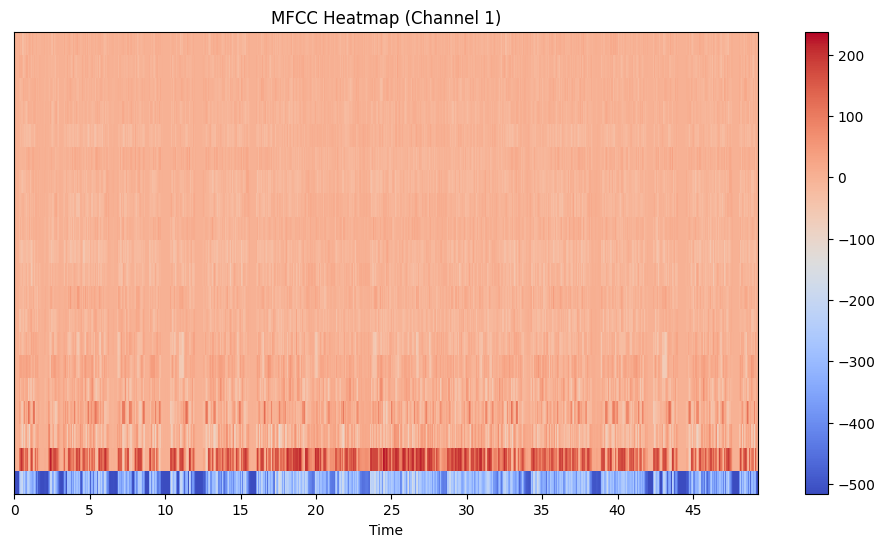

✅ Saved MFCC data for Channel 1 (CSV + NPY)


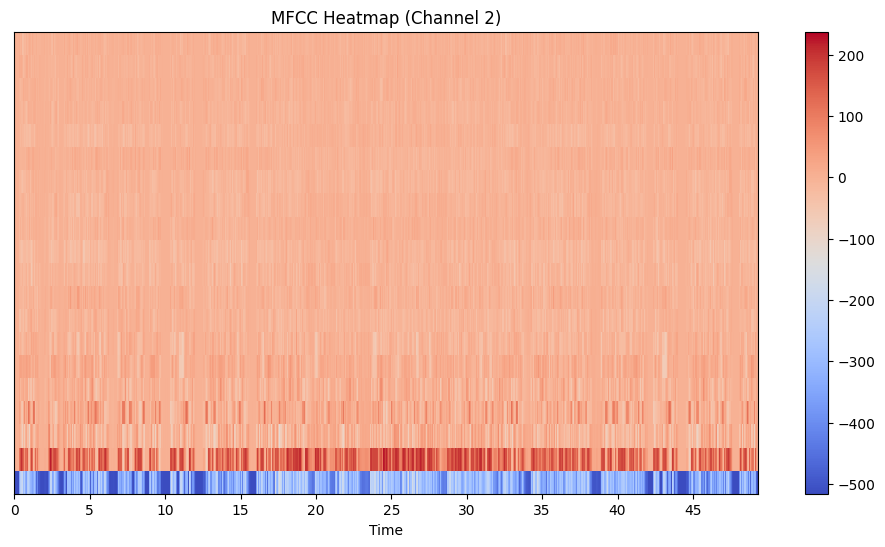

✅ Saved MFCC data for Channel 2 (CSV + NPY)

🔍 MFCC Summary Features (for ML input):
channel_1: (40,) → Example: [-3.4247574e+02  1.0193730e+02 -3.5197401e+00  1.2916637e+01
 -1.1320149e-01]...
channel_2: (40,) → Example: [-3.4247559e+02  1.0193726e+02 -3.5198462e+00  1.2916792e+01
 -1.1319419e-01]...


In [2]:
# -------------------------------
# STEP 1: Extract audio from video
# -------------------------------
def extract_audio(video_path, audio_path="output_audio.wav"):
    video = mp.VideoFileClip(video_path)
    video.audio.write_audiofile(audio_path, codec='pcm_s16le')
    return audio_path

# -------------------------------
# STEP 2: Analyze Audio with MFCC
# -------------------------------
def analyze_audio(audio_path, save_features=True):
    # Load audio
    y, sr = librosa.load(audio_path, sr=None, mono=False)

    # Check Mono/Stereo
    if y.ndim == 1:
        print("Audio Type: MONO")
        channels = 1
        y = [y]  # make it iterable
    else:
        print("Audio Type: STEREO")
        channels = y.shape[0]

    all_features = {}

    for i, channel in enumerate(y):
        # -------------------------------
        # STEP 3: MFCC Extraction
        # -------------------------------
        mfccs = librosa.feature.mfcc(y=channel, sr=sr, n_mfcc=20)  # 20 coefficients
        delta_mfcc = librosa.feature.delta(mfccs)                   # Delta features
        delta2_mfcc = librosa.feature.delta(mfccs, order=2)         # Delta-Delta features

        # Visualize MFCCs
        plt.figure(figsize=(12, 6))
        librosa.display.specshow(mfccs, x_axis="time", sr=sr, cmap="coolwarm")
        plt.colorbar()
        plt.title(f"MFCC Heatmap (Channel {i+1})")
        plt.show()

        # -------------------------------
        # STEP 4: Prepare Feature Data
        # -------------------------------
        # Flatten for ML use (mean + variance per coeff)
        mfcc_mean = np.mean(mfccs, axis=1)
        mfcc_var = np.var(mfccs, axis=1)

        feature_vector = np.concatenate([mfcc_mean, mfcc_var])

        all_features[f"channel_{i+1}"] = feature_vector

        # Save MFCC sequence (time series) for deep models (RNN/CNN)
        if save_features:
            np.save(f"mfcc_channel_{i+1}.npy", mfccs)
            pd.DataFrame(mfccs.T).to_csv(f"mfcc_channel_{i+1}.csv", index=False)
            print(f"✅ Saved MFCC data for Channel {i+1} (CSV + NPY)")

    # -------------------------------
    # STEP 5: Print Summary Features
    # -------------------------------
    print("\n🔍 MFCC Summary Features (for ML input):")
    for ch, feat in all_features.items():
        print(f"{ch}: {feat.shape} → Example: {feat[:5]}...")

    return all_features


# -------------------------------
# RUN PIPELINE
# -------------------------------
if __name__ == "__main__":
    video_file = "videoplayback.mp4"   # Change this to your video
    audio_file = "output_audio.wav"

    if not os.path.exists(audio_file):
        audio_file = extract_audio(video_file, audio_file)

    features = analyze_audio(audio_file)


Video Branch

In [ ]:
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
import cv2
import dlib
import os
import numpy as np
from tqdm import tqdm
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# -----------------------------
# CONFIG
# -----------------------------
VIDEO_PATH = "/content/videoplayback.mp4"   # Upload your deepfake video here
OUTPUT_DIR = "/content/aligned_frames"
IMG_SIZE = 224

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# -----------------------------
# Initialize Detectors
# -----------------------------
mtcnn_detector = MTCNN()
dlib_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# -----------------------------
# Align Face using Eyes
# -----------------------------
def align_face(image, landmarks):
    left_eye = (landmarks.part(36).x, landmarks.part(36).y)
    right_eye = (landmarks.part(45).x, landmarks.part(45).y)
    dx, dy = right_eye[0] - left_eye[0], right_eye[1] - left_eye[1]
    angle = np.degrees(np.arctan2(dy, dx))
    eyes_center = ((left_eye[0] + right_eye[0]) // 2,
                   (left_eye[1] + right_eye[1]) // 2)
    M = cv2.getRotationMatrix2D(eyes_center, angle, 1.0)
    aligned = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]),
                             flags=cv2.INTER_CUBIC)
    return aligned

# -----------------------------
# Process Single Frame (MULTI-FACE)
# -----------------------------
def preprocess_frame(frame, frame_id):
    detections = mtcnn_detector.detect_faces(frame)
    aligned_faces = []

    for i, det in enumerate(detections):
        x, y, w, h = det['box']
        x, y = max(0, x), max(0, y)
        face_crop = frame[y:y+h, x:x+w]

        if face_crop.size == 0:
            continue

        # Landmarks from Dlib
        gray = cv2.cvtColor(face_crop, cv2.COLOR_RGB2GRAY)
        rect = dlib.rectangle(0, 0, face_crop.shape[1], face_crop.shape[0])
        landmarks = dlib_predictor(gray, rect)

        aligned = align_face(face_crop, landmarks)

        # Resize + Normalize
        face_resized = cv2.resize(aligned, (IMG_SIZE, IMG_SIZE))
        face_normalized = face_resized.astype("float32") / 255.0

        # Save each face
        save_path = os.path.join(OUTPUT_DIR, f"frame_{frame_id}_face_{i}.jpg")
        cv2.imwrite(save_path, cv2.cvtColor((face_normalized * 255).astype("uint8"), cv2.COLOR_RGB2BGR))

        aligned_faces.append(face_normalized)

    return aligned_faces

# -----------------------------
# Process Video
# -----------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
frame_id, all_faces = 0, []

print("[INFO] Extracting & aligning multiple faces...")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = preprocess_frame(frame_rgb, frame_id)
    if faces:
        all_faces.extend(faces)
    frame_id += 1

cap.release()

faces_batch = np.array(all_faces)  # (N, 224, 224, 3)
print(f"[INFO] Completed ✅ Extracted {faces_batch.shape[0]} faces")

# ================================
# 4. Feature Extractor + MMNet
# ================================
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        base_model = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(base_model.children())[:-2])

    def forward(self, x):
        return self.backbone(x)   # (B,512,7,7)

class MMNet(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256, num_classes=2, dropout_p=0.5):
        super(MMNet, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.local_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.fc1 = nn.Linear(input_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        g = self.global_pool(x).reshape(x.size(0), -1)
        l = self.local_pool(x).reshape(x.size(0), -1)
        fusion = torch.cat([g, l], dim=1)
        out = F.relu(self.fc1(fusion))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# -----------------------------
# 5. Run Inference
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = FeatureExtractor().to(device)
model = MMNet(input_dim=512).to(device)

# (OPTIONAL) load pretrained weights
# model.load_state_dict(torch.load("mmnet_weights.pth", map_location=device))

# Freeze extractor (optional)
for p in feature_extractor.parameters():
    p.requires_grad = False

faces_tensor = torch.tensor(faces_batch).permute(0, 3, 1, 2).to(device)  # (N,3,224,224)

with torch.no_grad():
    feats = feature_extractor(faces_tensor)   # (N,512,7,7)
    outputs = model(feats)                    # (N,2)
    probs = F.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()
    fake_scores = probs[:,0].cpu().numpy()  # 0 = Fake, 1 = Real

# -----------------------------
# 6. Results Summary
# -----------------------------
real_count = np.sum(preds == 1)
fake_count = np.sum(preds == 0)
print(f"[RESULT] Real faces detected: {real_count}")
print(f"[RESULT] Fake faces detected: {fake_count}")

# -----------------------------
# 7. Visualization
# -----------------------------
def show_pred_samples(batch, preds, fake_scores, n=6):
    idxs = np.random.choice(len(batch), size=min(n, len(batch)), replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(idxs, 1):
        plt.subplot(1, n, i)
        plt.imshow(batch[idx])
        plt.axis("off")
        label = "Fake" if preds[idx] == 0 else "Real"
        score = fake_scores[idx]
        plt.title(f"{label}\nFake Score: {score:.2f}")
    plt.show()

show_pred_samples(faces_batch, preds, fake_scores, n=6)


[INFO] Extracting & aligning multiple faces...


Audio Branch

In [6]:
import torch
import numpy as np
import librosa
import torch.nn as nn

class FakeAudioDetector(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)   # (B,1,40,200)
        x = self.net(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load trained model ---
model = FakeAudioDetector().to(device)
model.load_state_dict(torch.load("fake_audio_detector.pth", map_location=device))
model.eval()  # important for inference

# --- Preprocess single audio ---
def preprocess_audio(file_path, n_mfcc=20, max_len=200):
    y, sr = librosa.load(file_path, sr=None, mono=True)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    feat = np.vstack([mfcc, delta])  # shape (40, time)

    # pad or trim to max_len
    if feat.shape[1] < max_len:
        pad_width = max_len - feat.shape[1]
        feat = np.pad(feat, ((0,0),(0,pad_width)), mode='constant')
    else:
        feat = feat[:, :max_len]

    # convert to tensor
    feat_tensor = torch.tensor(feat, dtype=torch.float32).unsqueeze(0).to(device)  # (1,40,max_len)
    return feat_tensor

# --- Predict single file ---
def predict_audio(file_path):
    feat = preprocess_audio(file_path)
    with torch.no_grad():
        output = model(feat)
        pred = torch.argmax(output, dim=1).item()
    label = "REAL" if pred == 0 else "FAKE"
    print(f"Prediction for {file_path}: {label}")
    return label

# --- Example usage ---
test_file = "output_audio.wav"   # change this to your audio
predict_audio(test_file)


Prediction for output_audio.wav: REAL


'REAL'

Lip Sync Analysis

  plt.legend()



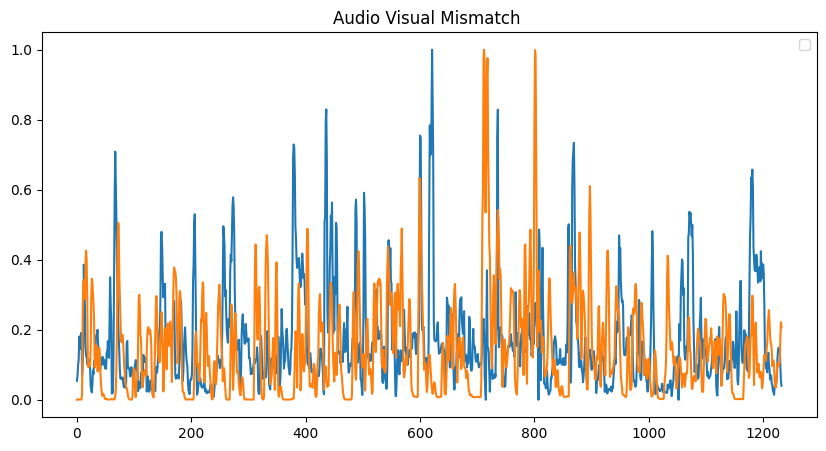

Lip-Sync Correlation Score: 0.06
⚠️ Possible Lip-Sync Issue


In [2]:

# -------------------------------
# STEP 1: Extract Audio from Video
# -------------------------------
video_path = "videoplayback.mp4"

# Save audio to a temporary file
temp_wav = tempfile.NamedTemporaryFile(suffix=".wav", delete=False).name
clip = mp_editor.VideoFileClip(video_path)
clip.audio.write_audiofile(temp_wav, verbose=False, logger=None)

# -------------------------------
# STEP 2: Get Audio Energy
# -------------------------------
y, sr = librosa.load(temp_wav)
frame_hop = int(sr / 30)  # match ~30 FPS
energy = librosa.feature.rms(y=y, frame_length=2048, hop_length=frame_hop)[0]

# Normalize energy
energy = (energy - np.min(energy)) / (np.max(energy) - np.min(energy))

# -------------------------------
# STEP 3: Extract Lip Distances from Video
# -------------------------------
mp_face_mesh = mp.solutions.face_mesh
cap = cv2.VideoCapture(video_path)

lip_distances = []

with mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1) as face_mesh:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb)

        if results.multi_face_landmarks:
            face_landmarks = results.multi_face_landmarks[0]
            h, w, _ = frame.shape

            # Upper lip (13) and lower lip (14)
            upper = face_landmarks.landmark[13]
            lower = face_landmarks.landmark[14]

            dist = np.linalg.norm(
                np.array([upper.x * w, upper.y * h]) -
                np.array([lower.x * w, lower.y * h])
            )
            lip_distances.append(dist)
        else:
            lip_distances.append(0)

cap.release()

# Normalize lip distances
lip_distances = np.array(lip_distances)
lip_distances = (lip_distances - np.min(lip_distances)) / (np.max(lip_distances) - np.min(lip_distances))

# -------------------------------
# STEP 4: Compare & Visualize
# -------------------------------
min_len = min(len(lip_distances), len(energy))
lip_distances = lip_distances[:min_len]
energy = energy[:min_len]

plt.figure(figsize=(10,5))

plt.legend()
plt.plot(lip_distances)
plt.plot(energy)
plt.title("Audio Visual Mismatch ")
plt.show()

# -------------------------------
# STEP 5: Simple Sync Check
# -------------------------------
correlation = np.corrcoef(lip_distances, energy)[0,1]
print(f"Lip-Sync Correlation Score: {correlation:.2f}")

if correlation > 0.6:
    print("✅ Lip-Sync looks GOOD")
else:
    print("⚠️ Possible Lip-Sync Issue")


Final Result
